# List of project's dependencies
Below are listed imports that are needed for program to work properly commented with required install (see also requirements.txt)

In [9]:
#List of imports
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys
sys.path.append('../../code')
from functions import *

### Divide data into tensors

In [10]:
X_train, X_test, y_train, y_test = price_preprocessing()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Compute on CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
X_validate = torch.tensor(np.array(X_validate), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1).to(device)
y_test  = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1).to(device)
y_validate  = torch.tensor(np.array(y_validate), dtype=torch.float32).reshape(-1, 1).to(device)

### MLP model 
Multilayer Perceptron 

In [11]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

 
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1

model = MLP(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [12]:
#Training the model
num_epochs = 100
batch_size = 100
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X).to(device)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validate)
        val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/100], Loss: 22707009536.0000
Epoch [20/100], Loss: 22475948032.0000
Epoch [30/100], Loss: 22490089472.0000
Epoch [40/100], Loss: 21992994816.0000
Epoch [50/100], Loss: 21884743680.0000
Epoch [60/100], Loss: 22066868224.0000
Epoch [70/100], Loss: 22071812096.0000
Epoch [80/100], Loss: 21941676032.0000
Epoch [90/100], Loss: 21851942912.0000
Epoch [100/100], Loss: 21797828608.0000
Loaded best model from epoch 100 with validation loss: 20275589120.0000
Test Loss: 19844157440.0


MSE: 19844159488.0
MAE: 104389.7734375
R-squared: 0.6857536815455882


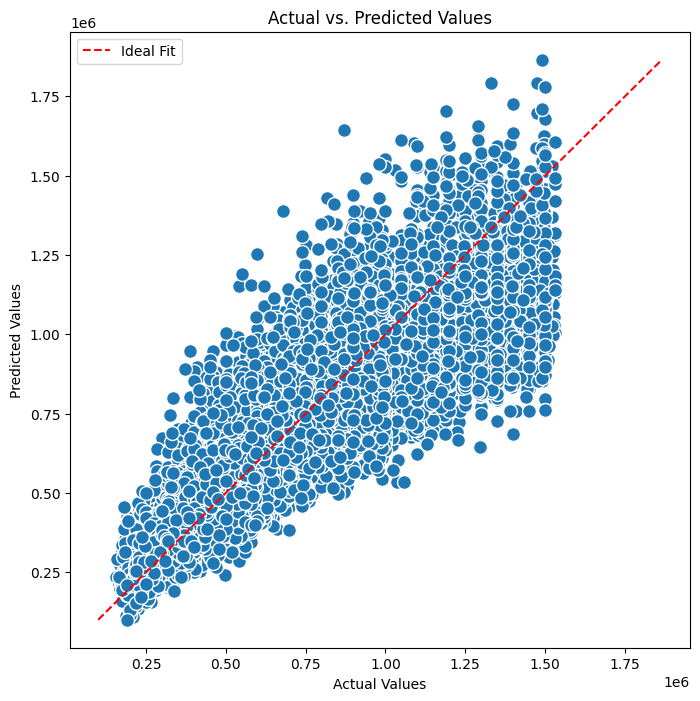

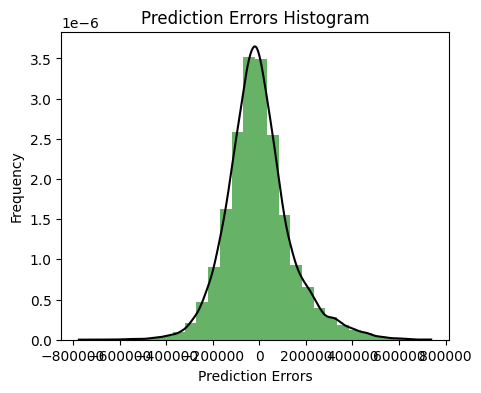

In [13]:
evaluate_model(
    true_data=np.asarray(y_test).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 70
hidden_size4 = 20
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [15]:
#Training the model
num_epochs = 200
batch_size = 40
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X).to(device)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validate)
        val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/200], Loss: 10519217152.0000
Epoch [20/200], Loss: 10438706176.0000
Epoch [30/200], Loss: 10722408448.0000
Epoch [40/200], Loss: 9583212544.0000
Epoch [50/200], Loss: 8161765376.0000
Epoch [60/200], Loss: 8617459712.0000
Epoch [70/200], Loss: 8173725184.0000
Epoch [80/200], Loss: 7129690112.0000
Epoch [90/200], Loss: 6827292160.0000
Epoch [100/200], Loss: 6807349248.0000
Epoch [110/200], Loss: 7010088960.0000
Epoch [120/200], Loss: 7140354560.0000
Epoch [130/200], Loss: 6918676992.0000
Epoch [140/200], Loss: 7128958464.0000
Epoch [150/200], Loss: 7219298816.0000
Epoch [160/200], Loss: 6991577600.0000
Epoch [170/200], Loss: 7740708352.0000
Epoch [180/200], Loss: 7325267456.0000
Epoch [190/200], Loss: 7443015168.0000
Epoch [200/200], Loss: 7295514112.0000
Loaded best model from epoch 145 with validation loss: 15577076736.0000
Test Loss: 15622667264.0


MSE: 15622665216.0
MAE: 92816.5546875
R-squared: 0.7942225242678723


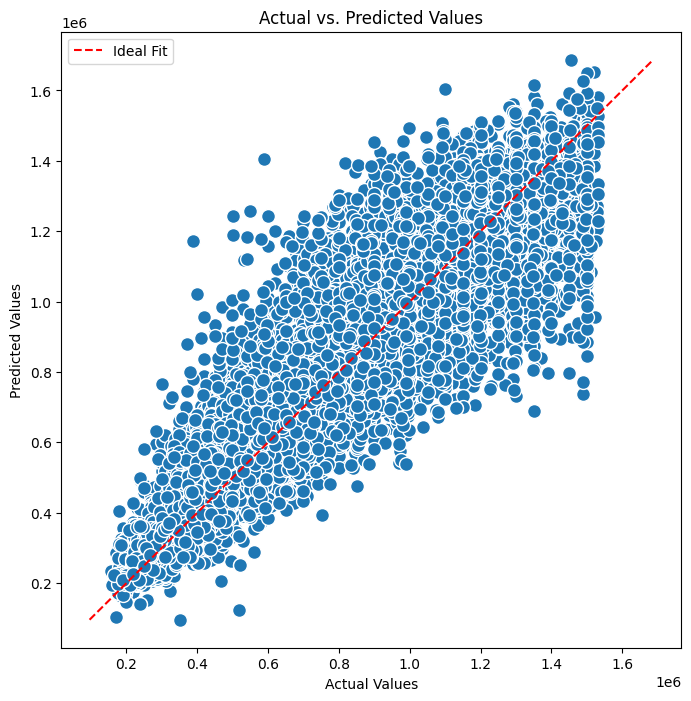

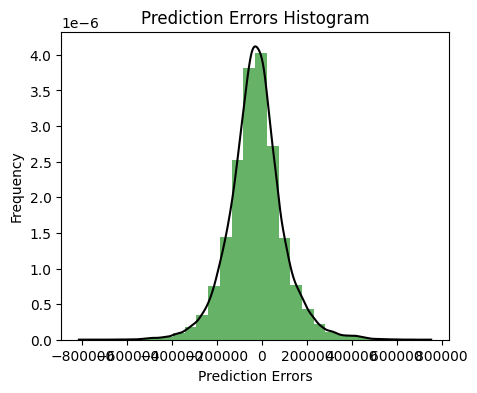

In [16]:
evaluate_model(
    true_data=np.asarray(y_test).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 100
hidden_size4 = 85
hidden_size5 = 50
hidden_size6 = 10
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [18]:
#Training the model
num_epochs = 500
batch_size = 24
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X).to(device)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validate)
        val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

Epoch [10/500], Loss: 14957553664.0000
Epoch [20/500], Loss: 16153740288.0000
Epoch [30/500], Loss: 15784650752.0000
Epoch [40/500], Loss: 19992268800.0000
Epoch [50/500], Loss: 17107934208.0000
Epoch [60/500], Loss: 18668134400.0000
Epoch [70/500], Loss: 18327066624.0000
Epoch [80/500], Loss: 19000537088.0000
Epoch [90/500], Loss: 17869154304.0000
Epoch [100/500], Loss: 12354964480.0000
Epoch [110/500], Loss: 13574418432.0000
Epoch [120/500], Loss: 16112167936.0000
Epoch [130/500], Loss: 16992985088.0000
Epoch [140/500], Loss: 16746158080.0000
Epoch [150/500], Loss: 16439777280.0000
Epoch [160/500], Loss: 18956056576.0000
Epoch [170/500], Loss: 17478529024.0000
Epoch [180/500], Loss: 17615339520.0000
Epoch [190/500], Loss: 13699468288.0000
Epoch [200/500], Loss: 16106663936.0000
Epoch [210/500], Loss: 16476277760.0000
Epoch [220/500], Loss: 15288388608.0000
Epoch [230/500], Loss: 13590235136.0000
Epoch [240/500], Loss: 17390307328.0000
Epoch [250/500], Loss: 18824552448.0000
Epoch [26

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
X_train, X_test, y_train, y_test = rent_preprocessing()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Compute on CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(np.array(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
X_validate = torch.tensor(np.array(X_validate), dtype=torch.float32).to(device)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32).reshape(-1, 1).to(device)
y_test  = torch.tensor(np.array(y_test), dtype=torch.float32).reshape(-1, 1).to(device)
y_validate  = torch.tensor(np.array(y_validate), dtype=torch.float32).reshape(-1, 1).to(device)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

 
input_size = X_train.shape[1]
hidden_size = 100
output_size = 1

model = MLP(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
#Training the model
num_epochs = 100
batch_size = 100
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X).to(device)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validate)
        val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 70
hidden_size4 = 20
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
#Training the model
num_epochs = 200
batch_size = 40
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X).to(device)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validate)
        val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.fc7 = nn.Linear(hidden_size6, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x
    
# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 100
hidden_size2 = 150
hidden_size3 = 100
hidden_size4 = 85
hidden_size5 = 50
hidden_size6 = 10
output_size = 1

model = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, hidden_size5, hidden_size6, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
#Training the model
num_epochs = 500
batch_size = 24
best_val_loss = float('inf')
best_epoch = -1
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(batch_X).to(device)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validate)
        val_loss = criterion(val_outputs, y_validate)


    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = model.state_dict()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.load_state_dict(best_model_state)
print(f'Loaded best model from epoch {best_epoch+1} with validation loss: {best_val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test)
    test_loss = criterion(y_pred_tensor, y_test)
    print('Test Loss:', test_loss.item())

# Convert predictions and true labels back to numpy arrays
y_pred_tensor_cpu = y_pred_tensor.to("cpu")
y_pred = y_pred_tensor_cpu.numpy()
y_true = y_test.to("cpu").numpy()

In [ ]:
evaluate_model(
    true_data=np.asarray(y_test).flatten(), 
    predicted_data=np.asarray(y_pred).flatten()
)